# Lab 3: Ambient noise data processing

The goal of this Lab is to introduce you to a variety of signal analysis tools that can be used for processing ambient noise data. The test dataset comes from Iceland, where the Cambridge volcano seismology group has been running portable arrays of broadband seismic stations for the last few decades.

The first step of the practical requires you to have obspy installed. Obspy is a powerful module that provides a python framework for processing and manipulating seismic data. If you installed Jupyter Notebook via Anaconda, you can install obspy using a command sequence like

conda config --add channels conda-forge <br>
conda create -n obspy python=3.7 <br>
conda activate obspy <br>
conda install obspy


In [1]:
# This cell contains some custom functions that will be used later.
# You can run it (shift + enter) and skip to the next part

import obspy   # obspy is a module for processing seismic data
import matplotlib.pyplot as plt
import numpy as np
import json 
import pickle
from scipy.stats.mstats import winsorize
from scipy.signal import correlate

def plot_data(st):
    try:
        data_to_plot = st[0].data
        times = st[0].times()
    except:
        data_to_plot = st.data
        times = st.times()
    times = times - max(times)/2
    fig,ax=plt.subplots(figsize=(12,3))
    ax.plot(times,data_to_plot)
    ax.set_xlabel('Time, s',size=14)
    ax.set_ylabel('Norm. Amplitude',size=14)
    plt.show()
    
def stack_days(folder,start_date,end_date):
    from obspy import UTCDateTime
    assert UTCDateTime(end_date)>UTCDateTime(start_date)
    date = UTCDateTime(start_date)
    datas = []
    while UTCDateTime(date)<UTCDateTime(end_date):
        date = date + 24*60*60
        file_name = str(date)[:10]+'.SAC'
        file_path = os.path.join(folder_name,file_name)
        try: 
            tr0 = obspy.read(file_path)[0]
            datas.append(tr0.data)
        except:
            print(f'file does not exist: {file_name}')
    print(f'found {len(datas)} files\n')
    if len(datas)>0:
        tr_out = tr0.copy()
        tr_out.data = np.mean(datas,axis=0)
        return tr_out
    
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def correlation(tr1,tr2):
    tr0 = tr1.copy()
    cc=correlate(tr1_slice.data,tr2_slice.data,mode='same')
    tr0.data = cc
    return tr0

def get_stations_dist(s1,s2):
    stations_dict = json.load(open('./prac_data/station_locations_dict.json'))
    lat1=stations_dict[s1]['lat']
    lat2=stations_dict[s2]['lat']
    lon1=stations_dict[s1]['lon']
    lon2=stations_dict[s2]['lon']
    return haversine(lon1, lat1, lon2, lat2)


def move_out_plot(station_name,folder_name):
    fig,ax=plt.subplots(figsize=(12,6))

    ls = os.listdir(folder_name)
    for file_name in ls:
        s1s2 = file_name.split('.')[0]
        s1,s2 = s1s2.split('_')
        if station_name == s1:
            file_path = os.path.join(folder_name,file_name)
            dist = get_stations_dist(s1,s2)
            tr = obspy.read(file_path)[0]
            times = tr.times()
            times = times - max(times)/2
            data = 7*tr.data/tr.data.max()
            ax.plot(times,data+dist,c='k')
    ax.set_xlabel('Time, s',size=14)
    ax.set_ylabel('Distance, km/s',size=14)   
    
def plot_dc(s1,s2):
    dcs = pickle.load(open('./prac_data/Iceland.pick','rb'),encoding='latin1')
    if f'{s1}_{s2}' in dcs:
        p,v,_,_=dcs[f'{s1}_{s2}']
    elif f'{s2}_{s1}' in dcs:
        p,v,_,_=dcs[f'{s2}_{s1}']
    else:
        print('No data found for this pair')
        return
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(p,v,c='k')
    ax.set_xlabel('Period, s',size=14)
    ax.set_ylabel('Velocity, km/s',size=14)  


ModuleNotFoundError: No module named 'obspy'

## Part 1: Preprocessing and cross-correlation

In this first part, we will investigate how signal can be extracted from ambient noise data by using cross-correlation.

The link below shows a map of seismic stations in Iceland from an experiment called HOTSPOT which we will use in this practical:

https://www.google.com/maps/d/u/0/edit?mid=1rrAuB2VrM7N4ecT7xhTO6qbwNrlx2Piu&usp=sharing


The first step reads in data for two of the Icelandic stations (BORG and HOT19 - find them on the map) for the entire day of 10th January 1997. In this case, we will just look at the vertical component seismogram, which will ultimately yield EGFs that correspond to band-limited EGFs.


In [2]:
tr1=obspy.read('./prac_data/raw_data/II.BORG.10.BHZ.D.1997.010')[0] # tr1 now holds the data for station BORG  
tr2=obspy.read('./prac_data/raw_data/XD.HOT19..BHZ.D.1997.010')[0] # tr2 now holds the data for station HOT19  

Our goal is to cross correlate the signals from the two stations, but first some preproccsing is required.
The steps are:
1. Cut the data into shorter chunks
2. Reduce the sampling rate
3. Normalize and taper the signals

To start, we will look at the raw data for one station and check the sampling rate.

Raw data:


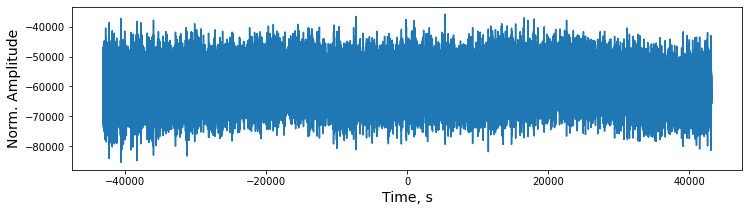

The sampling rate is: 40 samples per second


In [3]:
print('Raw data:')
plot_data(tr1)
print('The sampling rate is:',int(tr1.stats.sampling_rate),'samples per second')

We see we have 24 hours of data at 40 samples per second.
First we need to cut the data into shorter chunks and reduce the sampling rate


We will now take the first half an hour of data:

Half an hour of raw data:


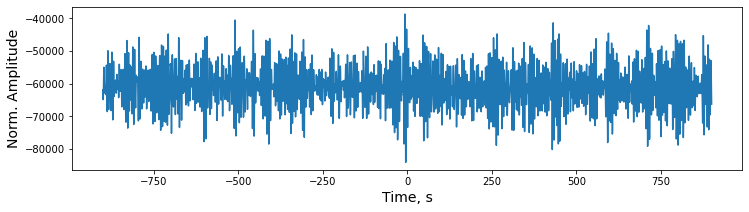

In [4]:
starttime=tr1.stats.starttime
endtime=starttime+60*30 #half an hour in seconds
tr1_slice=tr1.copy().slice(starttime,endtime)
print('Half an hour of raw data:')
plot_data(tr1_slice)

Now we remove any trends from the data and remove the mean so that it is centred around zero.

Mean and trend removed:


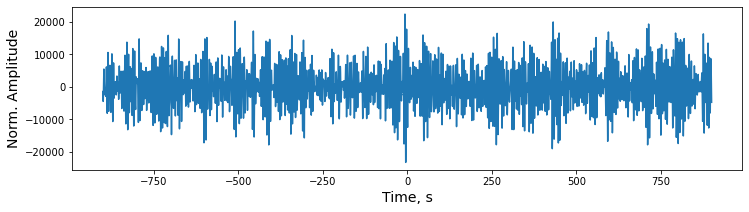

In [5]:
print('Mean and trend removed:')
tr1_slice.detrend('linear')
plot_data(tr1_slice)

Next we want to decimate the data to 1 sample per second.
To do this we must first filter the data with a lowpass filter at 0.5 Hz.
To avoid edge effects when filtering, we first apply a 5% taper to the data

Tapering:


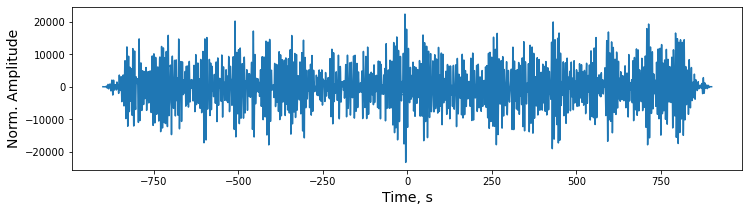

Filtering and decimating:


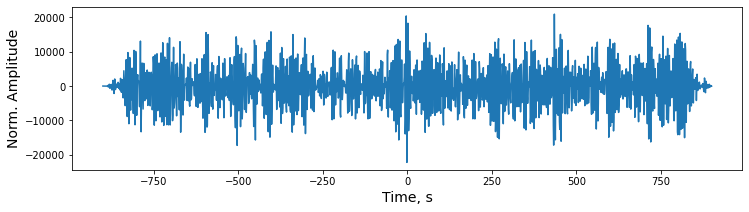

The new sampling rate is: 1 samples per second


In [6]:
print('Tapering:')
tr1_slice.taper(0.05)
plot_data(tr1_slice)
print('Filtering and decimating:')
tr1_slice.filter(type='lowpass',freq=0.5,zerophase=True)
# To get a sampling rate of 1 samples per second we need to decimate our signal by a factor of 40
# We decimate in two steps since obspy does not let you decimate using a number greater than 10
tr1_slice.decimate(10)
tr1_slice.decimate(4)
plot_data(tr1_slice)
print('The new sampling rate is:',int(tr1_slice.stats.sampling_rate),'samples per second')


Note the effect that tapering has on the ends of the waveform.

Finally, we want to suppress large amplitudes, which may be the result of earthquakes or local ground motion. This is done here through 1-bit normalisation, noting that tapering is still required.

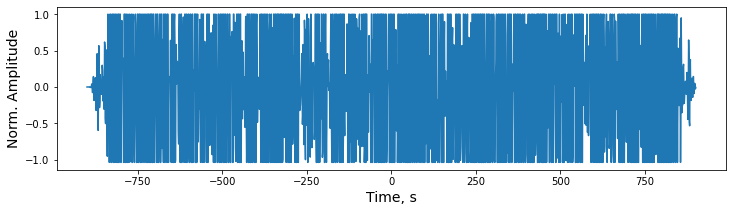

In [7]:
tr1_slice.data=winsorize(tr1_slice.data,0.25)
tr1_slice.data=tr1_slice.data/tr1_slice.data.max()
plot_data(tr1_slice)
print('Winsored trace:')

As an exercise, try repeating the above process with HOT19 to produce the time series tr2_slice.  Note that the sampling rate might be different, so decimate by the correct amount in order to produce 1 sample per second. Enter all relevant commands in the empty cell below and execute.

The sampling rate is: 20 samples per second
Half an hour of raw data:


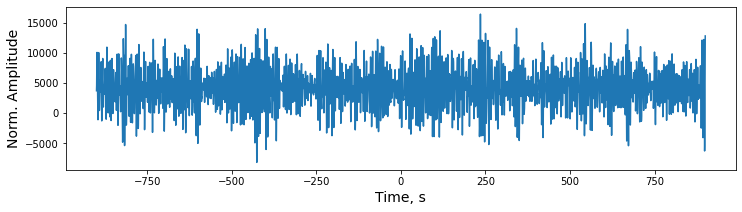

Mean and trend removed:


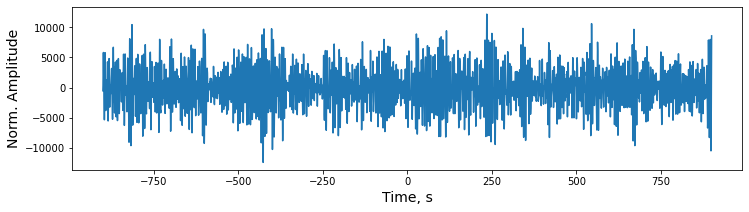

Tapering:


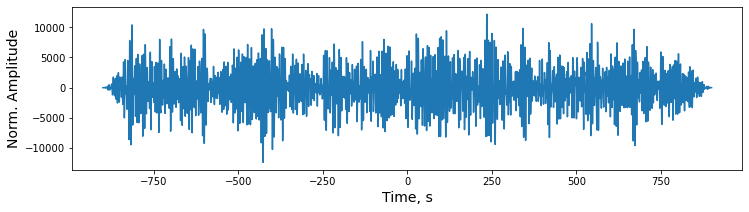

Filtering and decimating:


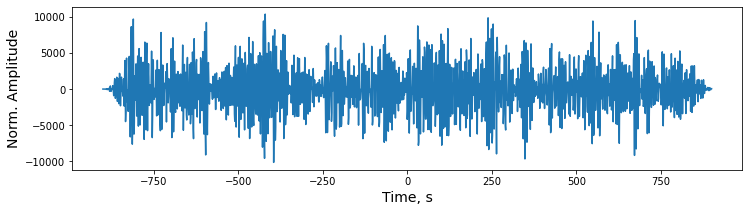

The new sampling rate is: 1 samples per second


In [8]:
print('The sampling rate is:',int(tr2.stats.sampling_rate),'samples per second')
starttime=tr2.stats.starttime
endtime=starttime+60*30 #half an hour in seconds
tr2_slice=tr2.copy().slice(starttime,endtime)
print('Half an hour of raw data:')
plot_data(tr2_slice)

print('Mean and trend removed:')
tr2_slice.detrend('linear')
plot_data(tr2_slice)

print('Tapering:')
tr2_slice.taper(0.05)
plot_data(tr2_slice)
print('Filtering and decimating:')
tr2_slice.filter(type='lowpass',freq=0.5,zerophase=True)
# To get a sampling rate of 1 samples per second we need to decimate our signal by a factor of 40
# We decimate in two steps since obspy does not let you decimate using a number greater than 10
tr2_slice.decimate(10)
tr2_slice.decimate(2)
plot_data(tr2_slice)
print('The new sampling rate is:',int(tr2_slice.stats.sampling_rate),'samples per second')

print('Winsored trace:')
tr2_slice.data=winsorize(tr2_slice.data,0.25)
tr2_slice.data=tr2_slice.data/tr2_slice.data.max()
plot_data(tr2_slice)

Now we can cross-correlate the two signals

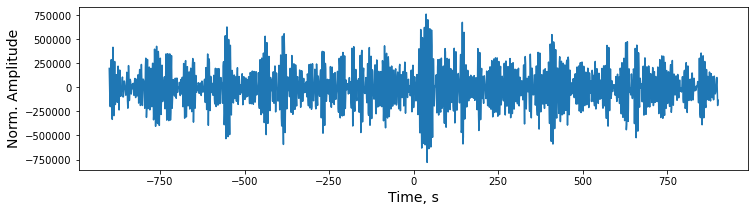

In [9]:
cc = correlation(tr1_slice,tr2_slice)
plot_data(cc)

You will observe that there is not much in the way of a clear signal on the causal or acausal components, but this is just a small snippet of data, and the signal will emerge as more data are added.

## Part 2 : Stacking
As you've learned, the first step in ambient noise analysis requires cross correlating the continuous seismic data for every simultaneously recording station pair. In the first part you have done this for half an hour of data. The next step is to repeat this process for the entire day, giving 48 cross correalations which are stacked (averaged) to give a daily (24 hr) cross correlation. To save time this has already been done for you for the station pair BORG and HOT19.

You have been given a folder named 'prac_data' which contains another folder named 'BORG_HO19'. Each of the files in this folder is the result of cross correlating the recordings at these two stations during one day.

Lets see what is in the folder.

In [10]:
import os #os is a python module for handling files and folders
folder_name = './prac_data/BORG_HOT19/' #path to folder
file_list = sorted(os.listdir(folder_name)) # make a list of files in the folder and sort it
print(file_list) # print the list

['1996-07-20.SAC', '1996-07-26.SAC', '1996-07-29.SAC', '1996-08-03.SAC', '1996-08-10.SAC', '1996-08-11.SAC', '1996-08-12.SAC', '1996-08-13.SAC', '1996-08-14.SAC', '1996-08-15.SAC', '1996-08-16.SAC', '1996-08-17.SAC', '1996-08-18.SAC', '1996-08-19.SAC', '1996-08-20.SAC', '1996-08-21.SAC', '1996-08-22.SAC', '1996-08-23.SAC', '1996-08-24.SAC', '1996-08-25.SAC', '1996-08-26.SAC', '1996-08-27.SAC', '1996-08-28.SAC', '1996-08-29.SAC', '1996-08-30.SAC', '1996-08-31.SAC', '1996-09-01.SAC', '1996-09-02.SAC', '1996-09-03.SAC', '1996-09-04.SAC', '1996-09-05.SAC', '1996-09-06.SAC', '1996-09-07.SAC', '1996-09-08.SAC', '1996-09-09.SAC', '1996-09-10.SAC', '1996-09-11.SAC', '1996-09-12.SAC', '1996-09-13.SAC', '1996-09-14.SAC', '1996-09-15.SAC', '1996-09-16.SAC', '1996-09-17.SAC', '1996-09-18.SAC', '1996-09-19.SAC', '1996-09-20.SAC', '1996-09-21.SAC', '1996-09-22.SAC', '1996-09-23.SAC', '1996-09-24.SAC', '1996-09-25.SAC', '1996-09-26.SAC', '1996-09-27.SAC', '1996-09-28.SAC', '1996-09-29.SAC', '1996-09-

For example, the file '1996-08-03.SAC' is the result of the cross correlation for August 3rd, 1996.

The extension ".SAC" signifies a type of seismic data file (binary format).

Write down the first and last days of data; you will need it later.

Let's have a look at this file:

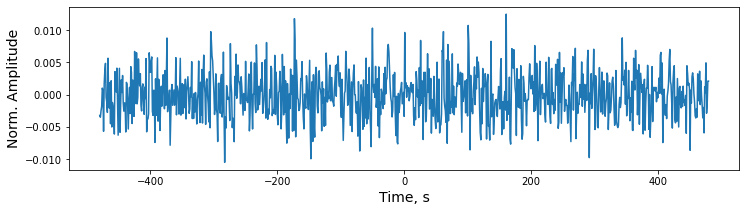

In [17]:
folder_name = './prac_data/BORG_HOT19/'
file_name = '1997-12-13.SAC' 
file_path = os.path.join(folder_name,file_name) # join the names of folder and file to get the correct path
data_in = obspy.read(file_path) # read the data from the file
plot_data(data_in) # plot the data

Can you see anything meaningful in the figure? Repeat the above for a few different dates at different times of the year. Can you see any difference?

Next we will try to stack multiple files together to get a better signal to noise ratio. Let's start with one week of data

file does not exist: 1997-02-24.SAC
file does not exist: 1997-02-25.SAC
file does not exist: 1997-04-07.SAC
file does not exist: 1997-04-08.SAC
file does not exist: 1997-04-09.SAC
file does not exist: 1997-04-10.SAC
file does not exist: 1997-04-11.SAC
file does not exist: 1997-04-12.SAC
file does not exist: 1997-07-01.SAC
file does not exist: 1997-07-22.SAC
found 171 files



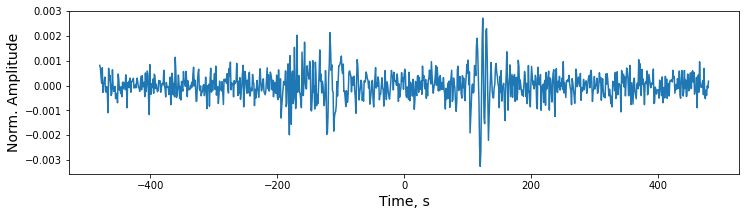

In [20]:
start_date = '1997-02-10'
end_date = '1997-08-10'
folder_name = './prac_data/BORG_HOT19/'
stacked_data = stack_days(folder_name,start_date,end_date) # Stack the data
plot_data(stacked_data) # Plot the stacked data

You may notice some files are missing, this probably means one of the stations did not record that day due to a malfunction

Can you see anything meaningful in the figure? Repeat the above using longer durations: one month, 3 months, 1 year and the entire date range. Describe what you see.

Is there a difference between using 3 months of data at different times of the year (i.e. winter, summer, etc.)? If so, why do you think that is? 

Find the coordinates of the two stations using the map (click on station icon) and find the distance between the two using the haversine function:

In [21]:
lat1 = 
lon1 = 
lat2 = 
lon2 = 
dist = haversine(lon1, lat1, lon2, lat2)
print(dist,'km')

343.7213810067609 km


Assuming surface waves travel at between 2 - 4 km/s, how long should the travel times between the two stations be? Does that agree with what you saw in the plot?

## Part 3 - Comparing different station pairs

The folder 'prac_data' contains another folder named 'stacked', this folder contains the  stacked cross correlations for every station pair. Let's see what is inside:

In [18]:
folder_name = './prac_data/stacked/' #path to folder
file_list = sorted(os.listdir(folder_name)) # make a list of files in the folder and sort it
print(file_list) # print the list

['BORG_HOT01.SAC', 'BORG_HOT02.SAC', 'BORG_HOT03.SAC', 'BORG_HOT04.SAC', 'BORG_HOT05.SAC', 'BORG_HOT06.SAC', 'BORG_HOT07.SAC', 'BORG_HOT08.SAC', 'BORG_HOT09.SAC', 'BORG_HOT10.SAC', 'BORG_HOT11.SAC', 'BORG_HOT12.SAC', 'BORG_HOT13.SAC', 'BORG_HOT14.SAC', 'BORG_HOT15.SAC', 'BORG_HOT16.SAC', 'BORG_HOT17.SAC', 'BORG_HOT18.SAC', 'BORG_HOT19.SAC', 'BORG_HOT20.SAC', 'BORG_HOT21.SAC', 'BORG_HOT22.SAC', 'BORG_HOT23.SAC', 'BORG_HOT24.SAC', 'BORG_HOT25.SAC', 'BORG_HOT26.SAC', 'BORG_HOT27.SAC', 'BORG_HOT28.SAC', 'BORG_HOT29.SAC', 'BORG_HOTT.SAC', 'HOT01_BORG.SAC', 'HOT01_HOT02.SAC', 'HOT01_HOT03.SAC', 'HOT01_HOT04.SAC', 'HOT01_HOT05.SAC', 'HOT01_HOT06.SAC', 'HOT01_HOT07.SAC', 'HOT01_HOT08.SAC', 'HOT01_HOT09.SAC', 'HOT01_HOT10.SAC', 'HOT01_HOT11.SAC', 'HOT01_HOT12.SAC', 'HOT01_HOT13.SAC', 'HOT01_HOT14.SAC', 'HOT01_HOT15.SAC', 'HOT01_HOT16.SAC', 'HOT01_HOT17.SAC', 'HOT01_HOT18.SAC', 'HOT01_HOT19.SAC', 'HOT01_HOT20.SAC', 'HOT01_HOT21.SAC', 'HOT01_HOT22.SAC', 'HOT01_HOT23.SAC', 'HOT01_HOT24.SAC', 'HOT0

For example, the file 'BORG_HOT19.SAC' is the stacked data for the station pair used above. This is how we would read it:


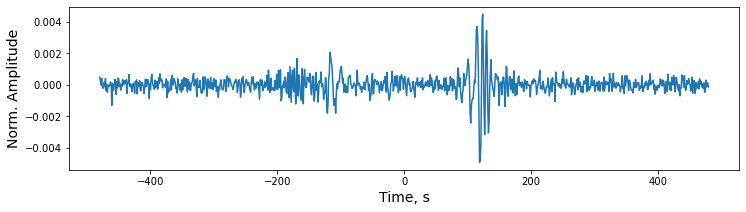

In [19]:
folder_name = './prac_data/stacked/'
file_name = 'BORG_HOT19.SAC' 
file_path = os.path.join(folder_name,file_name) 
data_in = obspy.read(file_path) 
plot_data(data_in)

Repeat the above with different pairs at different distances, what do you notice?

## Part 4: Move out plot

Next we want to plot all the stacked cross correlations that include the station BORG. 

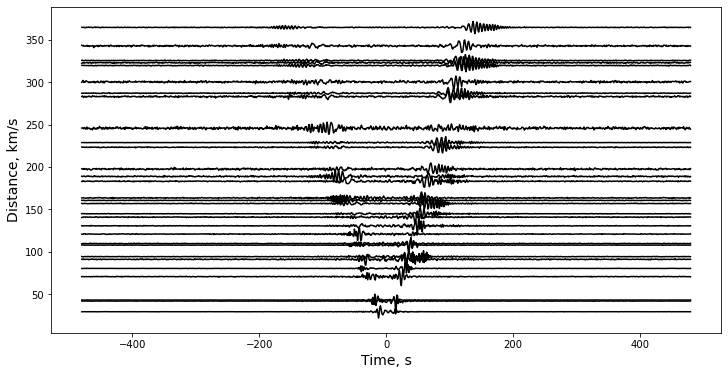

In [20]:
folder_name = './prac_data/stacked/'
station_name = 'BORG'
move_out_plot(station_name,folder_name)

Describe what you see, and estimate the approximate velocity of the surface wave EGFs.